<a href="https://colab.research.google.com/github/zronyj/instrumental/blob/master/QSRR_GC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relación Cuantitativa Estructura-Retención
## Introducción
¡Te damos la bienvenida a un cuaderno interactivo de [Colaboratory](https://marvinjs-demo.chemaxon.com/latest/demo.html)!

En esta ocasión vamos a construir modelos matemáticos/estadísticos con los que intentaremos predecir los tiempos de retención de diferentes sustancias sometidas a cromatografía de gases **-GC-**. Para esto vamos a utilizar el lenguaje de programación [Python](https://www.python.org/about/), los paquetes [RDKit](https://www.rdkit.org/docs/Overview.html), [NumPy](http://www.numpy.org/) y [scikit-learn](http://scikit-learn.org/stable/).

Para prepararnos, vamos a necesitar de instalar e importar todos los paquetes necesarios. Para ejecutar cada celda de trabajo, presiona **Shift + Enter**.

In [1]:
#Instalando paquetes necesarios para el calculo de descriptores
!apt-get install python-rdkit librdkit1 rdkit-data

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-freefont-ttf
Suggested packages:
  rdkit-doc
The following NEW packages will be installed:
  fonts-freefont-ttf librdkit1 python-rdkit rdkit-data
0 upgraded, 4 newly installed, 0 to remove and 8 not upgraded.
Need to get 16.2 MB of archives.
After this operation, 66.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-freefont-ttf all 20120503-7 [4,202 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 librdkit1 amd64 201603.5+dfsg-1ubuntu1 [2,013 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 rdkit-data all 201603.5+dfsg-1ubuntu1 [6,660 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-rdkit amd64 201603.5+dfsg-1ubuntu1 [3,372 kB]
Fetched 16.2 MB in 1s (11.7 MB/s)
Selecting previously unselected package fonts-freefont-ttf.
(

In [0]:
# Importando librerias
from sklearn import svm
from sklearn import tree
from sklearn import linear_model
from sklearn import neural_network
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
import numpy as np

## Teoría: Quantitative Structure Activity/Property Relationship -QSAR/QSPR-
Existe una teoría en la que se relaciona una **propiedad intrínseca** de una molécula con una **propiedad experimental** mediante un **modelo**. En palabras más sencillas, lo que se busca es relacionar algo que se sabe de antemano de una molécula (e.g. peso molecular) con un observable (e.g. punto de ebullición) mediante una fórmula.

$$Propiedad = f \left( prop.\ fisicoquimica / prop.\ estructural \right) + Error$$

La teoría se propuso originalmente para modelar actividad biológica, llegando a poder predecir el comportamiento de medicamentos, agroquímicos y materiales. En química, la teoría se ha utilizado para predecir *reactividad*, *toxicidad*, *potencial electroquímico*, *biodegradabilidad*, *tiempos de retención en cromatografía*, etc.

---

## Metodología
### Descriptores
En este caso en particular, vamos a intentar modelar los tiempos de retención en cromatografía de gases a partir de **descriptores estructurales**. Estos últimos son características estructurales de una molécula que se pueden calcular de manera teórica. Parte de un buen modelo QSRR es el saber escoger los descriptores que más información proveen sobre la propiedad deseada. Este tema ha sido ampliamente estudiado y es posible leer más en [Molecular Descriptors](http://www.moleculardescriptors.eu/). Los descriptores ofrecidos por RDKit se hallan descritos [en este enlace](http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors), aunque si deseas investigar otros y a mayor profundidad, puedes buscar en este libro: [Handbook of Molecular Descriptors](https://onlinelibrary.wiley.com/doi/book/10.1002/9783527613106).

### Modelo
Posteriormente, vamos a buscar cuál de los siguientes modelos da los mejores resultados:
* [Regresión Lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* [Árbol de Decisiones](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
* [Máquina de Soporte Vectorial](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)
* [Red Neural Artifical](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

Cada modelo utiliza un fundamento de matemática distinto y, aunque todos resultan realizando una regresión, cada modelo tiene sus ventajas y desventajas basado en la manera en que lo hace. **scikit-learn** provee todos los fundamentos matemáticos y los enlaces a los artículos científicos en su página si se desea profundizar en el tema.

### Propiedad
Esta es la cantidad más importante, pues sin ella el modelo no tiene sentido. La propiedad que vamos a utilizar son los tiempos de retención en GC de varias moléculas. Esta información la podemos encontrar en el artículo [Prediction of Gas Chromatographic Retention Times and Response Factors Using a General Qualitative Structure-Property Relationships Treatment](https://pubs.acs.org/doi/abs/10.1021/ac00083a005). Aunque el artículo también podemos encontrarlo en [este enlace](http://140.115.145.114/admin/fileup/files/20110302114300.pdf).

## Ejemplo
### QSPR: descriptores estructurales - punto de ebullición
Antes de comenzar con el estudio formal, vamos a comenzar viendo unos ejemplos. El primero es un ejemplo clásico en el curso de Química Orgánica. Vamos a buscar predecir el punto de ebullición de algunos alcoholes. Para eso vamos a hacer uso del formato **SMILES** para introducir las moléculas al cuaderno interactivo. Para mayor información sobre el formato SMILES, podemos visitar [este enlace](http://www.daylight.com/dayhtml/doc/theory/theory.smiles.html). La alternativa es dibujar las moléculas y luego exportarlas en el mismo formato utilizando [Marvin JS](https://marvinjs-demo.chemaxon.com/latest/demo.html).

In [0]:
# Definiendo los alcoholes con los que se trabajara
# Entradas = "nombre":["SMILES", punto de ebullicion]
alcoholes = {"metanol":["CO",64.7],
             "etanol":["CCO",78.4],
             "propanol":["CCCO",97.0],
             "isopropanol":["C(C)CO",82.6],
             "butanol":["CCCCO",117.7],
             "isobutanol":["C(C)CCO",108.0],
             "tertbutanol":["C(C)(C)CO",82.2],
             "pentanol":["CCCCCO",138.0],
             "isoamilico":["C(C)CCCO",131.0],
             "tertamilico":["CCC(C)(C)O",102.0],
             "hexanol":["CCCCCCO",157.0],
             "isohexilico":["C(C)CCCCO",151.9],
             "neopentilico":["C(C)(C)(C)CO",113.5],
             "heptanol":["CCCCCCCO",175.8],
             "isoheptilico":["C(C)CCCCCO",151.9],
             "octanol":["CCCCCCCCO",188.0],
             "decanol":["CCCCCCCCCCO",232.9],
             "isodecilico":["C(C)CCCCCCCCO",220.0],
             "dodecanol":["CCCCCCCCCCCCO",259.0]}

Ahora vamos a convertir los SMILES en objetos *molécula* de RDKit para después poder calcular sus propiedades. Estas operaciones siempre se deben de hacer.

In [0]:
alcobjetos = {}
nombres = alcoholes.keys()
for n in nombres:
  x = Chem.MolFromSmiles(alcoholes[n][0])
  x.SetProp("_Name",n)
  x = Chem.AddHs(x)
  AllChem.EmbedMolecule(x)
  AllChem.MMFFOptimizeMolecule(x)
  alcobjetos[n] = [x, alcoholes[n][1]]

Ahora que ya contamos con cada una de las moléculas con sus respectivos hidrógenos y con una geometría optimizada en 3D, podemos comenzar a calcular los descriptores.

In [0]:
# Creamos una funcion que nos calcule todos los descriptores
def obtener_descriptores(molecula):
  logP = Descriptors.MolLogP(molecula)
  molw = Descriptors.MolWt(molecula)
  balj = Descriptors.BalabanJ(molecula)
  rota = Descriptors.NumRotatableBonds(molecula)
  return [logP, molw, balj, rota]

In [0]:
cuantos = len(nombres)
descriptoles = [0] * cuantos
valores = [0] * cuantos
for i in xrange(cuantos):
  n = nombres[i]
  descriptoles[i] = obtener_descriptores(alcobjetos[n][0])
  valores[i] = alcobjetos[n][1]

Ya con los descriptores calculados como una matriz y con los valores de puntos de ebullición como un vector, vamos a convertir esto en formato NumPy y entrenar nuestros modelos con scikit-learn.

In [8]:
descriptoles = np.array(descriptoles)
valores = np.array(valores)

# Regresion lineal
reg = linear_model.LinearRegression().fit(descriptoles, valores)
print "Regresion lineal - R2: ", reg.score(descriptoles, valores)

# Arbol de decision
arbol = tree.DecisionTreeRegressor().fit(descriptoles, valores)
print "Arbol de decision - R2: ", arbol.score(descriptoles, valores)

# Maquina de soporte vectorial
msv = svm.LinearSVR().fit(descriptoles, valores)
print "Maquina de SV - R2: ", msv.score(descriptoles, valores)

# Red neural artifical
# Las redes neurales son los modelos mas complejos
# Estos llevan mucha calibracion y deben de entenderse a profundidad
rna = neural_network.MLPRegressor(hidden_layer_sizes=(50,50), solver="lbfgs",
                                  activation="logistic", alpha=0.001,
                                  max_iter=750)
# Debemos normalizar los datos previamente
normalizar = MinMaxScaler(feature_range=(0, 1))
normalizar.fit(descriptoles)
descript = normalizar.transform(descriptoles)
# Ahora ya podemos entrenar la red
rna.fit(descript, valores)
print "Red neural - R2: ", rna.score(descript, valores)


Regresion lineal - R2:  0.9759486384755583
Arbol de decision - R2:  0.9898807111099519
Maquina de SV - R2:  0.9513700664917737
Red neural - R2:  0.9898804001196404


Ahora que ya conocemos los $R^2$ de cada modelo, podemos escoger el que mejor nos pareció y aplicarlo a un nuevo dato. Vamos a probarlo con la molécula de alcohol isononílico.

In [9]:
# Escribimos el SMILES
isononilico = "C(C)CCCCCCCO"
# Convertimos la molecula en objeto RDKit
y = Chem.MolFromSmiles(isononilico)
y.SetProp("_Name","isononilico")
y = Chem.AddHs(y)
AllChem.EmbedMolecule(y)
AllChem.MMFFOptimizeMolecule(y)
# Calculamos descriptores

dy = np.array([obtener_descriptores(y)])
print "Segun regresion lineal:", round( reg.predict(dy)[0], 2 )
print "Segun arbol de decision:", round( arbol.predict(dy)[0], 2 )
print "Segun maquina de SV:", round( msv.predict(dy)[0], 2 )
ndy = normalizar.transform(dy)
print "Segun red neural:", round( rna.predict(ndy)[0], 2 )

Segun regresion lineal: 204.95
Segun arbol de decision: 188.0
Segun maquina de SV: 203.44
Segun red neural: 204.01


¡Y con esto acaba el ejemplo! Obtuvimos una aproximación del punto de ebullición del alcohol isononílico en base a varias técnicas. Ahora lo importante es buscar qué tan cerca están estas técnicas del valor real.

---

## Proyecto
Después de haber visto un ejemplo de cómo se utilizan valores experimentales, descriptores y un modelo matemático para construir un modelo estructura-propiedad, es momento de trabajar con más datos y algo más aplicado. A continuación se te presentan una tabla con 149 datos del artículo antes mencionado. Tu tarea consta de lo siguiente:
1. Convertir los SMILES a **objetos RDKit**
2. Encontrar **qué descriptores** utilizarás en tu estudio
3. **Calcular los descriptores** de tu elección
4. Escoger **qué modelos** vas a probar
5. **Entrenar los modelos** y calcular el coeficiente de determinación $R^2$
6. **Calcular el tiempo de retención** de una molécula que se te dará al momento de realizar este proyecto

Vale la pena recordar un par de cosas:
* Los descriptores es bueno calcularlos todos con una función
* Las redes neurales son delicadas; cuesta bastante trabajo calibrarlas
* ¡Muchos éxitos!


In [0]:
# Definiendo las moleculas con las que se trabajara
# Entradas = "nombre":["SMILES", tiempo de retencion]
moleculas = { "heptano":["CCCCCCC",1.78],
              "decano":["CCCCCCCCCC",4.59],
              "dodecano":["CCCCCCCCCCCC",6.34],
              "pentadecano":["CCCCCCCCCCCCCCC",8.56],
              "eicosano":["CCCCCCCCCCCCCCCCCCCC",11.55],
              "ciclohexano":["C1CCCCC1",1.53],
              "1-octeno":["C=CCCCCCC",2.53],
              "1-deceno":["C=CCCCCCCCC",4.45],
              "benceno":["C1=CC=CC=C1",1.46],
              "tolueno":["C1(C)=CC=CC=C1",2.23],
              "o-xileno":["C1(C)=C(C)C=CC=C1",3.43],
              "etilbenceno":["C1(CC)=CC=CC=C1",3.12],
              "propilbenceno":["C1(CCC)=CC=CC=C1",4.04],
              "alilbenceno":["C1(CC=C)=CC=CC=C1",3.93],
              "anisol":["C1(OC)=CC=CC=C1",3.59],
              "mesitileno":["C1(C)=CC(C)=CC(C)=C1",4.18],
              "a-metilestireno":["C1(C(=C)C)=CC=CC=C1",4.27],
              "ciclohexilbenceno":["C1(C2CCCCC2)=CC=CC=C1",7.24],
              "hexametilbenceno":["C1(C)=C(C)C(C)=C(C)C(C)=C1(C)",8.21],
              "4-fenil-1-buteno":["C=CCC(C1=CC=CC=C1)",4.87],
              "bifenilo":["C1(C2=CC=CC=C2)=CC=CC=C1",7.60],
              "cumeno":["C1(C(C)C)=CC=CC=C1",3.75],
              "indano":["C1(CCC2)=C2C=CC=C1",4.79],
              "tetralina":["C1(CCCC2)=C2C=CC=C1",5.92],
              "difenilmetano":["C1(CC2=CC=CC=C2)=CC=CC=C1",7.96],
              "estilbeno":["C1(/C=C/C2=CC=CC=C2)=CC=CC=C1",9.79],
              "naftaleno":["C1(C=CC=C2)=C2C=CC=C1",6.09],
              "1-bencilnaftaleno":["C1(C=CC=C2)=C2C(C3=CC=CC=C3)=CC=C1",11.39],
              "1,1'-binaftil":["C1(C=CC=C2)=C2C(C3=C(C=CC=C4)C4=CC=C3)=CC=C1",14.14],
              "fenantreno":["C1(C(C=CC=C3)=C3C=C2)=C2C=CC=C1",10.27],
              "antraceno":["C1(C=C(C=CC=C3)C3=C2)=C2C=CC=C1",10.34],
              "fluoreno":["C1=C(C(C=CC=C3)=C3C2)C2=CC=C1",10.28],
              "bibencilo":["C1(CC(C2=CC=CC=C2))=CC=CC=C1",8.61],
              "1-octanol":["CCCCCCCCO",5.10],
              "1-decanol":["CCCCCCCCCCO",6.77],
              "1-dodecanol":["CCCCCCCCCCCCO",8.26],
              "ciclopentanol":["C1(O)CCCC1",2.32],
              "ciclohexanol":["C1(O)CCCCC1",3.27],
              "fenol":["C1(O)=CC=CC=C1",4.16],
              "p-cresol":["C1(O)=CC=C(C)C=C1",5.02],
              "m-cresol":["C1(O)=CC(C)=CC=C1",5.03],
              "o-cresol":["C1(O)=C(C)C=CC=C1",4.84],
              "2-etilfenol":["C1(O)=C(CC)C=CC=C1",5.58],
              "4-etilfenol":["C1(O)=CC=C(CC)C=C1",5.81],
              "4-isopropilfenol":["C1(O)=CC=C(C(C)C)C=C1",6.32],
              "2-isopropilfenol":["C1(O)=C(C(C)C)C=CC=C1",6.11],
              "2-isopropoxifenol":["C1(O)=C(O(C(C)C))C=CC=C1",5.95],
              "alcohol bencílico":["C1(C(O))=CC=CC=C1",4.64],
              "1-naftol":["C1(C=CC=C2)=C2C=CC=C1O",8.41],
              "5,6,7,8-tetrahidro-1-naftol":["C1(CCCC2)=C2CCCC1O",8.02],
              "1,3-propanodiol":["C(O)CCO",2.65],
              "1,4-butanodiol":["C(O)CCCO",3.72],
              "1,6-dihidroxinaftaleno":["C1(CCC=C2)=C2CCC=C1",10.33],
              "1,7-dihidroxinaftaleno":["C1(CCC=C2)=C2C=CCC1",10.30],
              "octilamina":["C(N)CCCCCCC",4.88],
              "decilamina":["C(N)CCCCCCCCC",6.62],
              "dodecilamina":["C(N)CCCCCCCCCCC",8.14],
              "ciclohexilamina":["C1(N)CCCCC1",3.05],
              "cicloheptilamina":["C1(N)CCCCCC1",4.40],
              "di-n-butilamina":["C(NCCCC)CCC",4.18],
              "anilina":["C1(N)C=CC=CC=C1",4.08],
              "bencilamina":["C1(CN)C=CC=CC=C1",4.47],
              "o-toluidina":["C1(N)C(C)=CC=CC=C1",5.00],
              "p-toluidina":["C1(N)C=CC(C)=CC=C1",5.02],
              "N-metilanilina":["C1(NC)=CC=CC=C1",4.94],
              "difenilamina":["C1(NC2=CC=CC=CC2)=CC=CC=C1",9.16],
              "furfural":["C1(CO)=CC=CCC1",2.73],
              "2,4-dimetil-3-pentanona":["CC(C)C(O)C(C)C",2.43],
              "propiofenona":["C1(C(O)CC)=CC=CC=C1",5.82],
              "ciclopentanona":["C1(O)CCCC1",2.26],
              "ciclohexanona":["C1(O)CCCCC1",3.25],
              "cicloheptanona":["C1(O)CCCCCC1",4.42],
              "ciclohexilfenilcetona":["C1(C(C2=CC=CC=CC2)O)=CC=CC=C1",9.14],
              "benzofenona":["C1(C(O)C2=CC=CC=CC2)=CC=CC=C1",9.23],
              "acetofenona":["C1(C(O)C)=CC=CC=C1",4.93],
              "1-tetralona":["C1CC2=CC=CC=C2C(=O)C1",7.48],
              "1,4-naftoquinona":["C1=CC=C2C(=O)C=CC(=O)C2=C1",7.68],
              "benzaldehido":["C1(C=O)=CC=CC=CC1",3.92],
              "p-tolualdehido":["C1(C=O)=CC=C(C)C=C1",5.10],
              "trans-cinnamaldehido":["C1=CC=C(C=C1)C=CC=O",6.63],
              "hexanonitrilo":["C(C#N)CCCCC",3.06],
              "benzonitrilo":["C1(C#C)=CC=CC=C1",4.10],
              "1-bromodecano":["C(Br)CCCCCCCCC",7.42],
              "clorociclohexano":["C1(Cl)CCCCC1",3.36],
              "bromobenceno":["C1(Br)=CC=CC=C1",3.75],
              "yodobenceno":["C1(I)=CC=CC=C1",4.74],
              "p-clorotolueno":["C1(Cl)=CC=C(C)C=C1",4.03],
              "p-bromotolueno":["C1(Br)=CC=C(C)C=C1",5.24],
              "1-bromonaftaleno":["C1(C=CC=C2)=C2C(Br)=CC=C1",8.33],
              "eter difenilico":["C1(OC2=CC=CC=C2)=CC=CC=C1",7.74],
              "eter bencilfenilico":["C1(OCC2=CC=CC=C2)=CC=CC=C1",8.87],
              "eter butilfenilico":["C1(OCCCC)=CC=CC=C1",6.08],
              "1,3,5-trimetoxibenceno":["C1(OC)=CC(OC)=CC(OC)=C1",7.68],
              "sulfuro de dioctilo":["CCCCCCCCSCCCCCCCC",10.90],
              "sulfuro de difenilo":["C1(S(C2=CC=CC=C2))=CC=CC=C1",9.02],
              "tioanisol":["C1(SC)=CC=CC=C1",5.16],
              "sulfuro de metilbencilo":["C1(CSC)=CC=CC=C1",5.88],
              "1-metilpiperazina":["C1N(C)CCNC1",2.98],
              "quinolina":["C1(N=CC=C2)=C2C=CC=C1",6.45],
              "isoquinolina":["C1(C=NC=C2)=C2C=CC=C1",6.65],
              "1,2,3,4-tetrahidroquinolina":["C1(NCCC2)=C2C=CC=C1",7.17],
              "1,2,3,4-tetrahidroisoquinolina":["C1(CNCC2)=C2CC=CC=C1",6.75],
              "indol":["C1(NC=C2)=C2C=CC=C1",6.81],
              "benzimidazol":["C1=CC=C2C(=C1)NC=N2",8.02],
              "quinaldina":["CC1=NC2=CC=CC=C2C=C1",7.04],
              "fenantridina":["C1=CC=C2C(=C1)C=NC3=CC=CC=C23",10.49],
              "acridina":["C1=CC=C2C(=C1)C=C3C=CC=CC3=N2",10.35],
              "1-metil-2-piridona":["CN1C=CC=CC1=O",5.78],
              "tiofeno":["C1=CSC=C1",1.49],
              "pirrol":["C1=CNC=C1",2.04],
              "dibenzofurano":["C1=CC=C2C(=C1)C3=CC=CC=C3O2",8.60],
              "dibenzotiofeno":["C1=CC=C2C(=C1)C3=CC=CC=C3S2",10.11],
              "benzotiazol":["C1=CC=C2C(=C1)N=CS2",6.33],
              "3-picolina":["CC1=CN=CC=C1",2.97],
              "4-picolina":["CC1=CC=NC=C1",2.98],
              "2-picolina":["CC1=CC=CC=N1",2.56],
              "2,3-lutidina":["CC1=C(N=CC=C1)C",3.80],
              "2,4-lutidina":["CC1=CC(=NC=C1)C",3.66],
              "2,6-lutidina":["CC1=NC(=CC=C1)C",3.23],
              "4-etilpiridina":["CCC1=CC=NC=C1",3.97],
              "2-etilpiridina":["CCC1=CC=CC=N1",3.44],
              "3-etilpiridina":["CCC1=CN=CC=C1",3.92],
              "2,4,6-colidina":["C1=C(C)C(C)=NC=C(C)1",0.87],
              "3-cianopiridina":["C1=C(C#N)C=NC=C1",4.19],
              "4-cianopiridina":["C1(C#N)=CC=NC=C1",3.89],
              "3-piridincarboxaldehido":["C1=C(C=O)C=NC=C1",4.17],
              "2-acetilpiridina":["C1=CC(C=O)=NC=C1",4.60],
              "3-acetilpiridina":["C1=C(C=O)C=NC=C1",5.20],
              "2-amino-4,6-dimetilpiridina":["C1(C)=CC(N)=NC(C)=C1",5.85],
              "4-(2-aminoetil)piridina":["C1=CC(NCC)=NC=C1",6.08],
              "etil pipecolinato":["CCOC(=O)C1CCCCN1",6.11],
              "2-(2-hidroxietil)piridina)":["C1=CC(CCO)=NC=C1",5.63],
              "etil isonicotinato":["CCOC(=O)C1=CC=NC=C1",6.04],
              "2,2'-bipiridina":["C1=CC=NC(=C1)C2=CC=CC=N2",7.98],
              "acido ciclohexanocarboxilico":["C1CCC(CC1)C(=O)O",5.62],
              "acido nonanoico":["CCCCCCCCC(=O)O",6.76],
              "acido fenilacetico":["C1=CC=C(C=C1)CC(=O)O",6.54],
              "acido 4-fenilbutirico":["C1=CC=C(C=C1)CCCC(=O)O",7.86],
              "acido trans-cinamico":["C1=CC=C(C=C1)C=CC(=O)O",7.86],
              "acido 2,4,6-trimetilbenzoico":["CC1=CC(=C(C(=C1)C)C(=O)O)C",7.82],
              "carbonato de dietilo":["CCOC(=O)OCC",2.29],
              "acetato de bencilo":["CC(=O)OCC1=CC=CC=C1",5.73],
              "benzoato de fenilo":["C1=CC=C(C=C1)C(=O)OC2=CC=CC=C2",9.42],
              "cumarina":["C1=CC=C2C(=C1)C=CC(=O)O2",7.87],
              "dihidrocumarina":["C1CC(=O)OC2=CC=CC=C21",7.46],
              "isocromona":["C1COCC2=CC=CC=C21",4.13],
              "metilfenil sulfoxido":["CS(=O)C1=CC=CC=C1",7.07],
              "nitrobenceno":["C1=CC=C(C=C1)[N+](=O)[O-]",5.09],
              "p-nitrotolueno":["CC1=CC=C(C=C1)[N+](=O)[O-]",6.24]}

In [0]:
objetos = {}
nombres = moleculas.keys()
for n in nombres:
  x = Chem.MolFromSmiles(moleculas[n][0])
  Chem.Kekulize(x)
  x.SetProp("_Name",n)
  x = Chem.AddHs(x)
  AllChem.EmbedMolecule(x)
  AllChem.MMFFOptimizeMolecule(x)
  objetos[n] = [x, moleculas[n][1]]

In [0]:
# Funcion para calcular descriptores
def deseo_descriptores(molecula):
  # Aqui van los calculos de descriptores
  # y se van colocando en variables diferentes
  # que al final se combinan
  return []

In [0]:
# Esta funcion te puede ayudar si deseas visualizar alguna
# de las moleculas en la lista
def mostrar(molecula):
  x = objetos[molecula][0]
  AllChem.Compute2DCoords(x)
  x = Chem.RemoveHs(x)
  Draw.MolToMPL(x,size=(100,100))

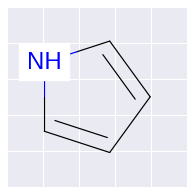

In [14]:
# Se utiliza de esta manera
mostrar("pirrol")